To run the notebook, you must install skfeature:

`pip3 install skfeature-chappers`

To install skfeature-chapper.

In [19]:
import generate_data as gd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, SelectPercentile
from sklearn.preprocessing import MinMaxScaler
from skfeature.function.similarity_based import fisher_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from filters import lda,knn, run_filters
import time
from sklearn.metrics import accuracy_score

import pylab
import warnings
warnings.filterwarnings('ignore')
pylab.rcParams['figure.figsize'] = (8.0, 8.0)

In [13]:
nr_features = 30
X,y = gd.gaussian_clusters(nr_features=nr_features, nr_classes=20, \
                           nr_data_points=100, random_diag=True, variance_size=8)

print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

(2000, 30)


### Original Classification using KNN

In [58]:
def orig_class(X_train, X_test, y_train, y_test, class_alg=KNeighborsClassifier()):
  
    start_t = time.time()
    model = class_alg.fit(X_train,y_train)

    y_test_pred = model.predict(X_test)

    orig_acc = accuracy_score(y_test, y_test_pred)
    orig_time = time.time() - start_t

    return orig_time, orig_acc

### Variance Threshold feature selection and classification

In [70]:
def vt_feat_sel(X_train, X_test, y_train, y_test, class_alg=KNeighborsClassifier()):

    t_start = time.time()
    var = np.zeros(len(X_train[0,:]))
  
    for i in range(len(X_train[0,:])):
    
        var[i] = np.var(X_train[:,i])
    
        ind_max_var = np.argsort(var)
  
    vt_acc = np.zeros(len(X_train[0,:]))
  
    for i in range(len(X_train[0,:])):
    
        X_temp = X_train[:,ind_max_var[0:(i+1)]]
        X_test_temp = X_test[:,ind_max_var[0:(i+1)]]

        class_alg.fit(X_temp, y_train)

        y_test_pred = class_alg.predict(X_test_temp)
        vt_acc[i] = accuracy_score(y_test, y_test_pred, normalize=True)
    
    vt_time = time.time()-t_start  
    vt_max_acc = max(vt_acc)
    vt_selected_features = np.argmax(vt_acc)

    return vt_time, vt_max_acc, vt_selected_features + 1

In [3]:
best_ks, best_scores, times, f_scores_filtered_knn, f_scores_filtered_lda, mi_scores_filtered_knn, \
mi_scores_filtered_lda, chi2_scores_filtered_knn, \
chi2_scores_filtered_lda = run_filters(X_train, y_train, X_test, y_test)


Order: f_score knn, mutual information knn, chi2 knn, f score lda, mutual information lda, chi2 lda


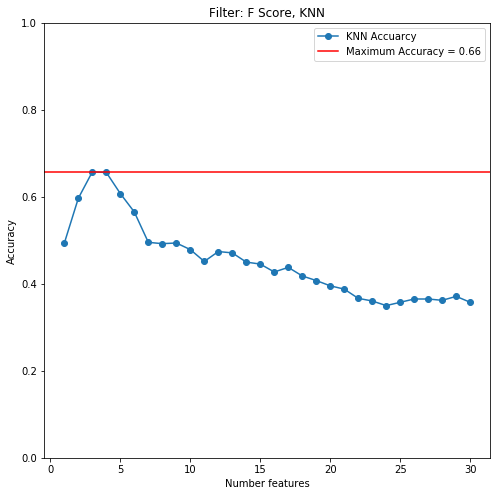

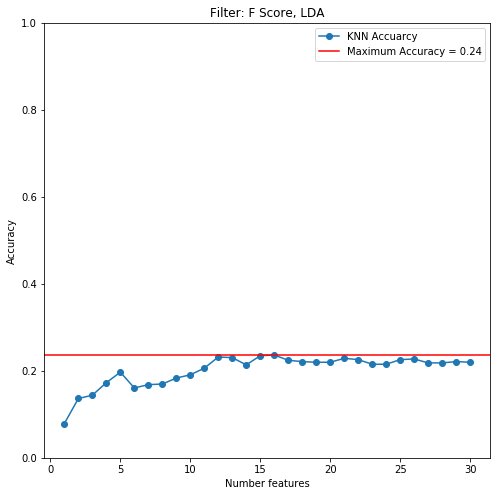

In [4]:
save_figs = False

plt.title("Filter: F Score, KNN")
ax = plt.plot(range(1,nr_features+1), f_scores_filtered_knn, marker='o')
plt.ylim((0, 1))
plt.xlabel("Number features")
plt.ylabel("Accuracy")

plt.axhline(y=max(f_scores_filtered_knn), c='r')
labels = ["KNN Accuarcy", "Maximum Accuracy = {:0.2f}".format(max(f_scores_filtered_knn))]
plt.legend(labels = labels)
if save_figs:
    plt.savefig("fscore-knn", dpi=300,
            orientation='portrait',
            transparent=False, bbox_inches=None, pad_inches=0.1)
    

plt.show()

plt.title("Filter: F Score, LDA")
plt.plot(range(1,nr_features+1), f_scores_filtered_lda, marker='o')
plt.ylim((0, 1))
plt.xlabel("Number features")
plt.ylabel("Accuracy")
plt.axhline(y=max(f_scores_filtered_lda),  c='r')
labels = ["KNN Accuarcy", "Maximum Accuracy = {:0.2f}".format(max(f_scores_filtered_lda))]
plt.legend(labels = labels)
if save_figs:
    plt.savefig("fscore-lda", dpi=300,
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1)

plt.show()

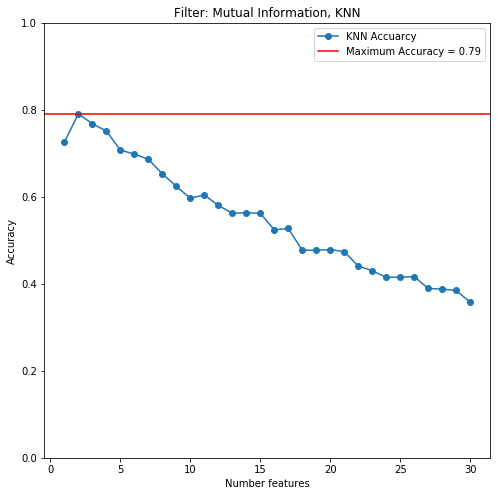

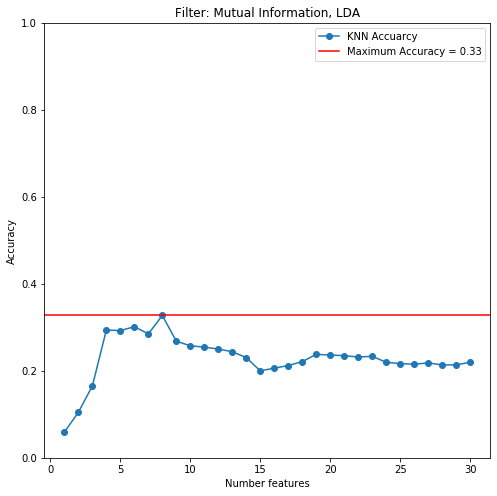

In [5]:
save_figs = False

plt.title("Filter: Mutual Information, KNN")
ax = plt.plot(range(1,nr_features+1), mi_scores_filtered_knn, marker='o')
plt.ylim((0, 1))
plt.xlabel("Number features")
plt.ylabel("Accuracy")

plt.axhline(y=max(mi_scores_filtered_knn), c='r')
labels = ["KNN Accuarcy", "Maximum Accuracy = {:0.2f}".format(max(mi_scores_filtered_knn))]
plt.legend(labels = labels)
if save_figs:
    plt.savefig("mi-knn", dpi=300,
            orientation='portrait',
            transparent=False, bbox_inches=None, pad_inches=0.1)
    

plt.show()

plt.title("Filter: Mutual Information, LDA")
plt.plot(range(1,nr_features+1), mi_scores_filtered_lda, marker='o')
plt.ylim((0, 1))
plt.xlabel("Number features")
plt.ylabel("Accuracy")
plt.axhline(y=max(mi_scores_filtered_lda),  c='r')
labels = ["KNN Accuarcy", "Maximum Accuracy = {:0.2f}".format(max(mi_scores_filtered_lda))]
plt.legend(labels = labels)
if save_figs:
    plt.savefig("fscore-lda", dpi=300,
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1)

plt.show()

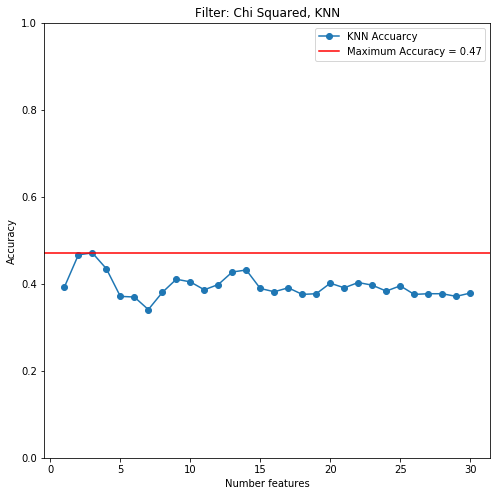

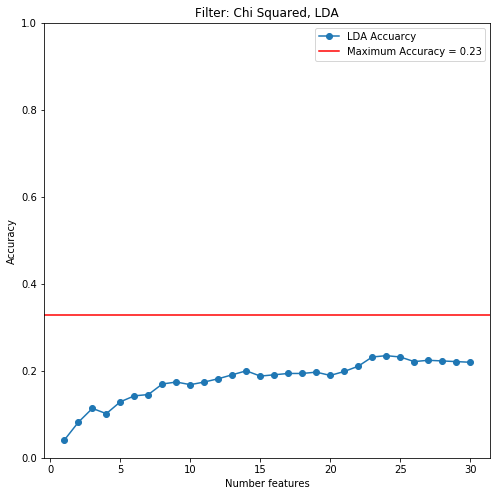

In [6]:
save_figs = False

plt.title("Filter: Chi Squared, KNN")
ax = plt.plot(range(1,nr_features+1), chi2_scores_filtered_knn, marker='o')
plt.ylim((0, 1))
plt.xlabel("Number features")
plt.ylabel("Accuracy")

plt.axhline(y=max(chi2_scores_filtered_knn), c='r')
labels = ["KNN Accuarcy", "Maximum Accuracy = {:0.2f}".format(max(chi2_scores_filtered_knn))]
plt.legend(labels = labels)
if save_figs:
    plt.savefig("mi-knn", dpi=300,
            orientation='portrait',
            transparent=False, bbox_inches=None, pad_inches=0.1)
    

plt.show()

plt.title("Filter: Chi Squared, LDA")
plt.plot(range(1,nr_features+1), chi2_scores_filtered_lda, marker='o')
plt.ylim((0, 1))
plt.xlabel("Number features")
plt.ylabel("Accuracy")
plt.axhline(y=max(mi_scores_filtered_lda),  c='r')
labels = ["LDA Accuarcy", "Maximum Accuracy = {:0.2f}".format(max(chi2_scores_filtered_lda))]
plt.legend(labels = labels)
if save_figs:
    plt.savefig("fscore-lda", dpi=300,
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1)

plt.show()

## Filtering for larger number of classes

Running the filters for up to 100 classes gives us. We are also skipping the LDA since they really suc

In [73]:
nr_features=40
nr_classes= np.array([2,5])
nr_points = 1000
variance_size = 8

f_score_accs = np.zeros(len(nr_classes))
mi_accs = np.zeros(len(nr_classes))
chi2_accs = np.zeros(len(nr_classes))
vt_accs = np.zeros(len(nr_classes))
orig_accs = np.zeros(len(nr_classes))


f_score_times =  np.zeros(len(nr_classes))
mi_times = np.zeros(len(nr_classes))
chi2_times = np.zeros(len(nr_classes))
vt_times = np.zeros(len(nr_classes))
orig_times = np.zeros(len(nr_classes))



for i,nc in enumerate(nr_classes):
    
    X,y = gd.gaussian_clusters(nr_features, nr_classes=nc, \
                           nr_data_points=nr_points, random_diag=True, variance_size=variance_size)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    orig_time, orig_acc = orig_class(X_train, X_test, y_train, y_test)
    
    best_ks, best_scores, times, f_scores_filtered_knn, f_scores_filtered_lda, mi_scores_filtered_knn, \
    mi_scores_filtered_lda, chi2_scores_filtered_knn, \
    chi2_scores_filtered_lda = run_filters(X_train, y_train, X_test, y_test)
    vt_time, vt_acc, vt_num_feat = vt_feat_sel(X_train, X_test, y_train, y_test)
    
    # Scores
    f_score_accs[i] = np.max(f_scores_filtered_knn)
    mi_accs[i] = np.max(mi_scores_filtered_knn)
    chi2_accs[i] = np.max(chi2_scores_filtered_knn)
    vt_accs[i] = np.max(vt_acc)
    orig_accs[i] = orig_acc
    
    
    # Times
    f_score_times[i] = times[0]
    mi_times[i] = times[1]
    chi2_times[i] = times[2]
    orig_times[i] = orig_time
    vt_times[i] = vt_time

Order: f_score knn, mutual information knn, chi2 knn, f score lda, mutual information lda, chi2 lda
[1.         1.         1.         1.         1.         1.
 0.99848485 0.9969697  0.99848485 0.99848485 0.9969697  0.9969697
 0.9969697  0.99848485 0.99848485 0.99848485 0.99848485 0.99848485
 0.99848485 0.99848485 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.99848485 0.9969697  0.9969697  0.99848485 0.99242424
 0.98636364 0.98636364 0.98484848 0.97878788]
Order: f_score knn, mutual information knn, chi2 knn, f score lda, mutual information lda, chi2 lda
[1.         1.         1.         0.99878788 0.99878788 0.99515152
 0.97030303 0.97090909 0.94       0.94969697 0.95333333 0.95939394
 0.96484848 0.95878788 0.95090909 0.95757576 0.94606061 0.93454545
 0.92969697 0.91939394 0.90969697 0.92666667 0.91272727 0.9169697
 0.90181818 0.90545455 0.88363636 0.89333333 0.87939394 0.88484848
 0.90121212 0.88121212 0.86363636 0.8648484

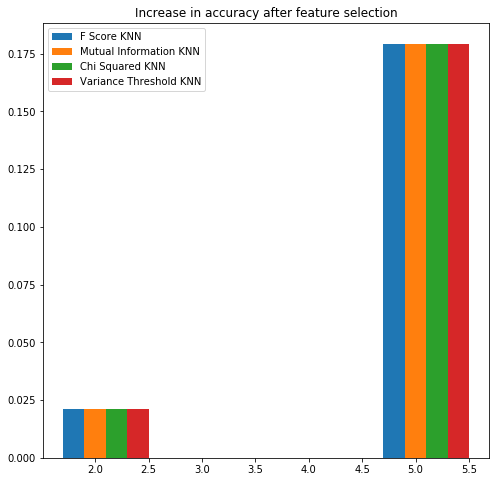

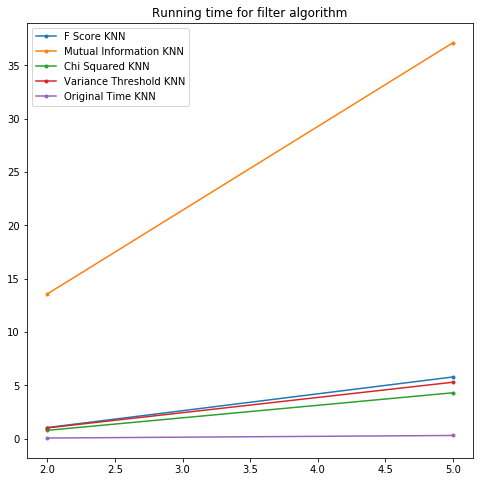

In [76]:
plt.title("Increase in accuracy after feature selection")
plt.bar(nr_classes-0.2, f_score_accs-orig_accs, label="F Score KNN", width=0.2, align='center')
plt.bar(nr_classes, mi_accs-orig_accs,  label="Mutual Information KNN",width=0.2)
plt.bar(nr_classes+0.2, chi2_accs-orig_accs,  label="Chi Squared KNN",width=0.2)
plt.bar(nr_classes+0.4, vt_accs-orig_accs,  label="Variance Threshold KNN",width=0.2)
plt.legend()
plt.show()

plt.title("Running time for filter algorithm")
plt.plot(nr_classes, f_score_times, marker='.', label="F Score KNN")
plt.plot(nr_classes, mi_times, marker='.', label="Mutual Information KNN")
plt.plot(nr_classes, chi2_times, marker='.', label="Chi Squared KNN")
plt.plot(nr_classes, vt_times, marker='.', label="Variance Threshold KNN")
plt.plot(nr_classes, orig_times, marker='.', label="Original Time KNN")
plt.legend()
plt.show()